In [1]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
import os
from gta_math import points_to_homo, ndc_to_view, construct_proj_matrix, view_to_world, construct_view_matrix, ndcs_to_pixels, grid_to_ndc_pcl_linear_view
from visualization import load_depth, save_pointcloud_csv
import progressbar
from pointcloud_to_voxelmap import pointclouds_to_voxelmap
from joblib import Parallel, delayed
from configparser import ConfigParser
from PIL import Image
import pickle
import json
from voxelmaps import camera_to_pointcloud, load_scene_db_data, get_main_image_name, scene_to_voxelmap, get_main_image, scene_to_voxelmap_with_map, ndc_pcl_to_grid_linear_view, generate_frustum_points, scene_to_pointcloud, pointclouds_to_voxelmap_with_map
import voxelmaps
import gta_math
import time

In [2]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

conn = visualization.get_connection_pooled()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = CONFIG["Images"]["Tiff"]
out_directory = CONFIG["Images"]["MlDatasetVoxel"]
out_inspect_directory = r'D:\showing-pointclouds'


In [3]:
#scene_id = '623b6ace-2a9c-4067-8c5f-42cb46d56f53' # from 4cameras on car run, I think
scene_id = '386b407b-586c-4d88-9d41-8dc2a0b70e70' # from voxelmap run

cameras = load_scene_db_data(scene_id)

base_name = get_main_image_name(cameras)

In [4]:
cam = get_main_image(cameras)
proj_matrix = cam['proj_matrix']
view_matrix = cam['view_matrix']
width = cam['width']
height = cam['height']

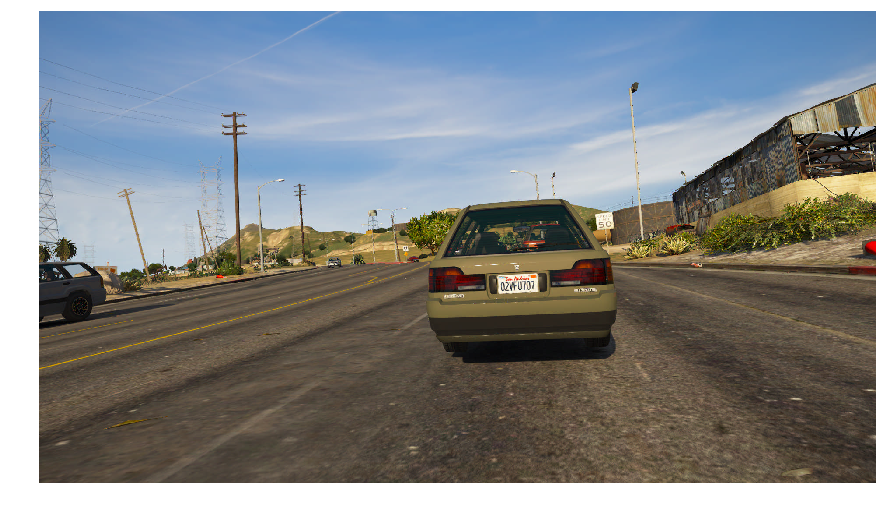

In [5]:
infile = os.path.join(in_directory, base_name+'.tiff')
im = Image.open(infile)
im = im.convert(mode="RGB")

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(im)
plt.show()

In [6]:
x_min = -1
x_max = 1
y_min = -1
y_max = 1
x_range = 240
y_range = 160
z_range = 100
z_meters_min = 1.5
z_meters_max = 25
voxelmaps.MAX_DISTANCE = 30
linear_view_sampling = True
gta_math.PROJECTING = True
subsampling_size = 0.12

In [8]:
start = time.time()
voxels, values, map_voxel_size, map_obj = scene_to_voxelmap_with_map(cameras, 1e-1)
print("time for scene to voxelmap: {}".format(time.time() - start))

occupied_voxels = voxels[:, values >= 0]
positions, z_max, z_min = generate_frustum_points(proj_matrix, x_range, y_range, z_range, z_meters_min, z_meters_max, linear_view_sampling)

MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
scene_to_pointcloud: 1.688000202178955
pointclouds_to_voxelmap_with_map: 5.744046688079834
time for scene to voxelmap: 7.43304705619812


In [17]:
params = {
    'width': width,
    'height': height,
    'proj_matrix': proj_matrix,
}

points_view = ndc_to_view(positions, proj_matrix)
points_world = view_to_world(points_view, view_matrix)
# here I find corresponding voxels for generated points, by obtaining voxelmap reference
voxel_values = map_obj.get_voxels(points_world[0:3, :], np.zeros((points_world.shape[1], 1)))
occupied_voxels_view = points_view[:, voxel_values > 0]
occupied_ndc_points = positions[:, voxel_values > 0]
invalid_ndc_points = positions[:, np.isnan(voxel_values)]

w = np.ones((1,occupied_voxels.shape[1]))
voxels_homo = np.vstack([occupied_voxels, w])
voxels_view = view_matrix @ voxels_homo

occupied_ndc_grid = ndc_pcl_to_grid_linear_view(x_range, y_range, z_range, occupied_ndc_points, proj_matrix, z_meters_min, z_meters_max)
invalid_ndc_grid = ndc_pcl_to_grid_linear_view(x_range, y_range, z_range, invalid_ndc_points, proj_matrix, z_meters_min, z_meters_max)

# unknown voxel values are nan, do we show then, so we can use them for invalid blacklist
invalid_voxels_view = points_view[:, np.isnan(voxel_values)]

print(np.sum(occupied_ndc_grid | invalid_ndc_grid))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


1468726


In [11]:
print('invalid values in grid: {} of total {}'.format(invalid_ndc_grid.sum(), invalid_ndc_grid.size))

invalid values in grid: 119014 of total 3840000


for max 25: ivalid values in grid: 131239 of total 3840000
for max 50: ivalid values in grid: 130149 of total 3840000
for max 100: ivalid values in grid: 129724 of total 3840000
for max 50: ivalid values in grid: 129227 of total 3840000


for:
voxelmaps.MAX_DISTANCE = 100
linear_view_sampling = True
gta_math.PROJECTING = True
subsampling_size = 1e-1
scene_to_pointcloud: 2.1230125427246094
pointclouds_to_voxelmap_with_map: 303.1749749183655
time for scene to voxelmap: 305.301988363266


for:
voxelmaps.MAX_DISTANCE = 50
linear_view_sampling = True
gta_math.PROJECTING = True
subsampling_size = 1e-1
scene_to_pointcloud: 1.790001392364502
pointclouds_to_voxelmap_with_map: 32.49322152137756
time for scene to voxelmap: 65.69841837882996


for:
voxelmaps.MAX_DISTANCE = 50
linear_view_sampling = True
gta_math.PROJECTING = True
subsampling_size = 0.12
scene_to_pointcloud: 1.7950108051300049
pointclouds_to_voxelmap_with_map: 34.8832368850708
time for scene to voxelmap: 38.972262144088745


for:
voxelmaps.MAX_DISTANCE = 30
linear_view_sampling = True
gta_math.PROJECTING = True
subsampling_size = 0.12
scene_to_pointcloud: 1.7570106983184814
pointclouds_to_voxelmap_with_map: 6.362040281295776
time for scene to voxelmap: 10.163077592849731

In [14]:
save_pointcloud_csv(invalid_voxels_view.T[:, 0:3], '{}/invalid-voxels-{}.csv'.format(out_inspect_directory, base_name))
save_pointcloud_csv(occupied_voxels_view.T[:, 0:3], '{}/occupied-voxels-{}.csv'.format(out_inspect_directory, base_name))


In [ ]:
plt.figure(figsize=(12, 12))
plt.hist(voxel_values, bins=200)
plt.show()

In [ ]:
print(points_view.shape)
print(voxel_values.shape)
print(invalid_voxels_view.shape)
print(invalid_ndc_grid.sum())
print(voxels.shape)

## and now trying to change depth for smaller voxelmaps
Depth is 0-1 and that is 1.5m to 10km in view. That leads to huge voxelmaps. 
We need the backround pixels to correctly determine empty space. 
Ommiting points far away will left us with undefined voxels in the air.
Taking them nearer, but still behind the space which will be sampled, will drastically lower the voxelmap size, but still let us with air voxels without obstacles and not undefined.

In [7]:
gta_math.PROJECTING = False
voxelmaps.MAX_DISTANCE = 11000

start = time.time()
pointclouds, cam_positions = scene_to_pointcloud(cameras, None)
print('scene_to_pointcloud:', time.time() - start)

print('pointcloud sizes: ', [pcl.shape for pcl in pointclouds])
print('total size: ', sum([pcl.shape[1] for pcl in pointclouds]))
total_pcl = np.hstack(pointclouds)
save_pointcloud_csv(total_pcl.T[:, 0:3], '{}/inspections-total-orig.csv'.format(out_inspect_directory, base_name))

gta_math.PROJECTING = False
voxelmaps.MAX_DISTANCE = 11000

start = time.time()
pointclouds, cam_positions = scene_to_pointcloud(cameras, 1e-1)
print('scene_to_pointcloud:', time.time() - start)

print('pointcloud sizes: ', [pcl.shape for pcl in pointclouds])
print('total size: ', sum([pcl.shape[1] for pcl in pointclouds]))
total_pcl = np.hstack(pointclouds)
save_pointcloud_csv(total_pcl.T[:, 0:3], '{}/inspections-total-sub.csv'.format(out_inspect_directory, base_name))

gta_math.PROJECTING = True
voxelmaps.MAX_DISTANCE = 30
start = time.time()
pointclouds, cam_positions = scene_to_pointcloud(cameras, None)
print('scene_to_pointcloud:', time.time() - start)

print('pointcloud sizes: ', [pcl.shape for pcl in pointclouds])
print('total size: ', sum([pcl.shape[1] for pcl in pointclouds]))
total_pcl = np.hstack(pointclouds)
save_pointcloud_csv(total_pcl.T[:, 0:3], '{}/inspections-total-proj30m.csv'.format(out_inspect_directory, base_name))

gta_math.PROJECTING = True
voxelmaps.MAX_DISTANCE = 30
start = time.time()
pointclouds, cam_positions = scene_to_pointcloud(cameras, 0.12)
print('scene_to_pointcloud:', time.time() - start)

print('pointcloud sizes: ', [pcl.shape for pcl in pointclouds])
print('total size: ', sum([pcl.shape[1] for pcl in pointclouds]))
total_pcl = np.hstack(pointclouds)
save_pointcloud_csv(total_pcl.T[:, 0:3], '{}/inspections-total-sub-proj30m.csv'.format(out_inspect_directory, base_name))


MAX_DISTANCE 11000
threshold [ -1.35811969e-05]
MAX_DISTANCE 11000
threshold [ -1.35811969e-05]
MAX_DISTANCE 11000
threshold [ -1.35811969e-05]
MAX_DISTANCE 11000
threshold [ -1.35811969e-05]
scene_to_pointcloud: 1.2650048732757568
pointcloud sizes:  [(3, 2067120), (3, 2067120), (3, 2067120), (3, 2067120)]
total size:  8268480
MAX_DISTANCE 11000
threshold [ -1.35811969e-05]


D:\Projects\GTAVisionExport_postprocessing\voxelmaps.py:86: UserWarning: pointcloud is same size after subsampling, something is wrong, probably voxelsize too small
  warnings.warn("pointcloud is same size after subsampling, something is wrong, probably voxelsize too small")


MAX_DISTANCE 11000
threshold [ -1.35811969e-05]
MAX_DISTANCE 11000
threshold [ -1.35811969e-05]
MAX_DISTANCE 11000
threshold [ -1.35811969e-05]
scene_to_pointcloud: 1.3399980068206787
pointcloud sizes:  [(3, 2067120), (3, 2067120), (3, 2067120), (3, 2067120)]
total size:  8268480
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
scene_to_pointcloud: 1.0740067958831787
pointcloud sizes:  [(3, 2067120), (3, 2067120), (3, 2067120), (3, 2067120)]
total size:  8268480
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
MAX_DISTANCE 30
projecting
threshold [ 0.04985753]
scene_to_pointcloud: 1.6410131454467773
pointcloud sizes:  [(3, 100218), (3, 97686), (3, 134915), (3, 135401)]
total size:  468220


In [9]:
np.hstack(pointclouds).shape

(3, 3726653)

In [ ]:
start = time.time()
assert (pointclouds[0].shape[0] == 3)
voxels, values, voxel_size, map_obj = pointclouds_to_voxelmap_with_map(pointclouds, cam_positions)
print('pointclouds_to_voxelmap_with_map:', time.time() - start)


In [11]:
voxelmaps.MAX_DISTANCE = 11000
gta_math.PROJECTING = False

start = time.time()
pointclouds, cam_positions = scene_to_pointcloud(cameras, None)

In [16]:
pointclouds[3].max(axis=1)

array([ 1234.19698162, -2548.90995468,    56.9664063 ])

In [ ]:
occupied_ndc_grid = ndc_pcl_to_grid_linear_view(x_range, y_range, z_range, occupied_ndc_points, proj_matrix, z_meters_min, z_meters_max)
invalid_ndc_grid = ndc_pcl_to_grid_linear_view(x_range, y_range, z_range, invalid_ndc_points, proj_matrix, z_meters_min, z_meters_max)
